In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

model = XGBClassifier(eval_metric='logloss')
import matplotlib.pyplot as plt

In [ ]:
# Load the dataset
df = pd.read_csv('/content/amazon_layoffs_2000_2024_.csv')

In [ ]:
# Step 1: Add binary target - Layoff_Event
df['Layoff_Event'] = df['Employees Laid Off'].apply(lambda x: 1 if x > 0 else 0)


In [ ]:
# Step 2: Simulate a few 'no-layoff' records
no_layoff_data = {
    'Date': ['15-06-2004', '20-09-2010', '10-01-2017'],
    'Department': ['Logistics', 'Sales', 'HR'],
    'Location': ['USA', 'India', 'Germany'],
    'Employees Laid Off': [0, 0, 0],
    'Total Employees(Before Layoff)': [20000, 30000, 25000],
    'Revenue (in Billion USD)': [10.5, 25.0, 50.2],
    'Net Profit (in Billion USD)': [1.5, 2.2, 5.0],
    'Stock Price (USD)': [50.0, 120.0, 200.0],
    'Layoff_Event': [0, 0, 0]
}
no_layoff_df = pd.DataFrame(no_layoff_data)
df = pd.concat([df, no_layoff_df], ignore_index=True)

In [ ]:
# Step 3: Feature selection
features = [
    'Date', 'Department', 'Location',
    'Total Employees(Before Layoff)', 'Revenue (in Billion USD)',
    'Net Profit (in Billion USD)', 'Stock Price (USD)'
]
X = df[features]
y = df['Layoff_Event']

In [ ]:
# Step 4: Encode categorical features (future_data must be defined later)
label_encoders = {}
# Store original X for use after future_data is created
X_original = X.copy()

In [ ]:
# Step 5: Handle datetime
X_original['Date'] = pd.to_datetime(X_original['Date'], format='%d-%m-%Y', errors='coerce')
X_original['Year'] = X_original['Date'].dt.year
X_original['Month'] = X_original['Date'].dt.month
X_original['Day'] = X_original['Date'].dt.day
X_original = X_original.drop('Date', axis=1)

In [ ]:
# Step 6: Feature scaling
numerical_features = [
    'Year', 'Month', 'Day',
    'Total Employees(Before Layoff)', 'Revenue (in Billion USD)',
    'Net Profit (in Billion USD)', 'Stock Price (USD)'
]
scaler = StandardScaler()
X_scaled = X_original.copy()

In [ ]:
# Placeholder for future_data (define after split)
future_data = pd.DataFrame([{
    'Department': 'Engineering',
    'Location': 'USA',
    'Total Employees(Before Layoff)': 180000,
    'Revenue (in Billion USD)': 600,
    'Net Profit (in Billion USD)': 20,
    'Stock Price (USD)': 300,
    'Year': 2025,
    'Month': 4,
    'Day': 6
}])

In [ ]:
# Placeholder for future_data (define after split)
future_data = pd.DataFrame([{
    'Department': 'Engineering',
    'Location': 'USA',
    'Total Employees(Before Layoff)': 180000,
    'Revenue (in Billion USD)': 600,
    'Net Profit (in Billion USD)': 20,
    'Stock Price (USD)': 300,
    'Year': 2025,
    'Month': 4,
    'Day': 6
}])

In [ ]:
# Fit LabelEncoders on combined unique values
for col in ['Department', 'Location']:
    le = LabelEncoder()
    all_values = pd.concat([X[col], future_data[col]]).unique()
    le.fit(all_values)
    X_scaled[col] = le.transform(X[col])
    future_data[col] = le.transform(future_data[col])
    label_encoders[col] = le

# Scale numeric features
X_scaled[numerical_features] = scaler.fit_transform(X_scaled[numerical_features])
future_data[numerical_features] = scaler.transform(future_data[numerical_features])

In [ ]:
# Step 7: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Step 8: Train classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Step 9: Evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
print("Confusion Matrix(AMAZON):\n", confusion_matrix(y_test, y_pred))

# Training predictions
y_train_pred = model.predict(X_train)

# Accuracy scores
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_pred)

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

print("\nTraining Classification Report(AMAZON):\n", classification_report(y_train, y_train_pred))

Confusion Matrix(AMAZON):
 [[ 0  1]
 [ 0 14]]
Training Accuracy: 96.43%
Test Accuracy: 93.33%

Training Classification Report(AMAZON):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.96      1.00      0.98        54

    accuracy                           0.96        56
   macro avg       0.48      0.50      0.49        56
weighted avg       0.93      0.96      0.95        56



In [ ]:
# Step 10: Predict future event (2025)
future_pred = model.predict(future_data)
future_proba = model.predict_proba(future_data)
print("Layoff Prediction(AMAZON)")
print("Layoff Prediction for 2025:", "YES" if future_pred[0] == 1 else "NO")
print("Layoff Probability:", round(future_proba[0][1] * 100, 2), "%")

Layoff Prediction(AMAZON)
Layoff Prediction for 2025: YES
Layoff Probability: 97.66 %


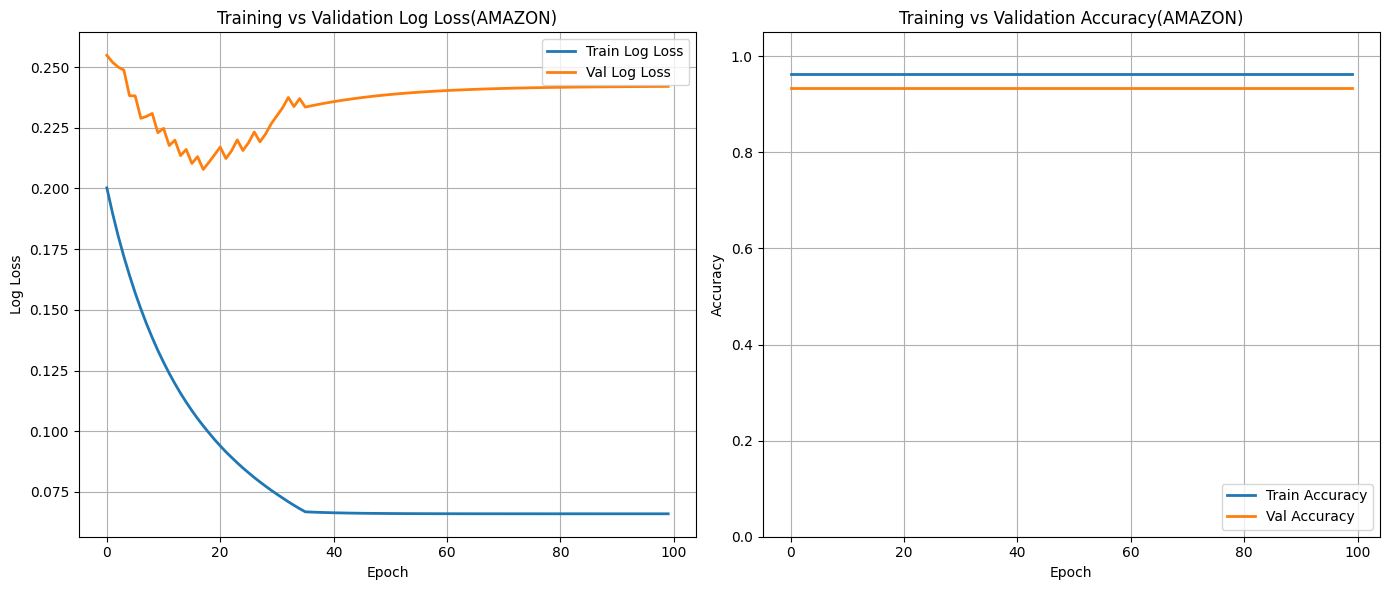

In [ ]:
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# 1. Prepare the eval set
eval_set = [(X_train, y_train), (X_test, y_test)]

# 2. Instantiate with metrics to track
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric=['logloss', 'error'],  # specify here
    n_estimators=100,
    learning_rate=0.1
)

# 3. Fit without passing eval_metric again
model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=False
)

# 4. Extract evaluation history
results = model.evals_result()

# 5. Number of boosting rounds (epochs)
epochs = len(results['validation_0']['logloss'])
x_axis = range(epochs)

# 6. Plot Log Loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(x_axis, results['validation_0']['logloss'], label='Train Log Loss', lw=2)
plt.plot(x_axis, results['validation_1']['logloss'], label='Val Log Loss',   lw=2)
plt.title('Training vs Validation Log Loss(AMAZON)')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend(loc='upper right')
plt.grid(True)

# 7. Plot Accuracy = 1 − error
train_acc = [1 - err for err in results['validation_0']['error']]
val_acc   = [1 - err for err in results['validation_1']['error']]

plt.subplot(1, 2, 2)
plt.plot(x_axis, train_acc, label='Train Accuracy', lw=2)
plt.plot(x_axis, val_acc,   label='Val Accuracy',   lw=2)
plt.title('Training vs Validation Accuracy(AMAZON)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1.05)
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()


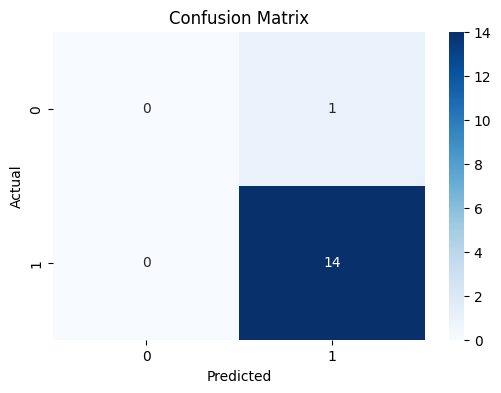

In [ ]:
# VALIDATION PLOTS
# Confusion Matrix Plot
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

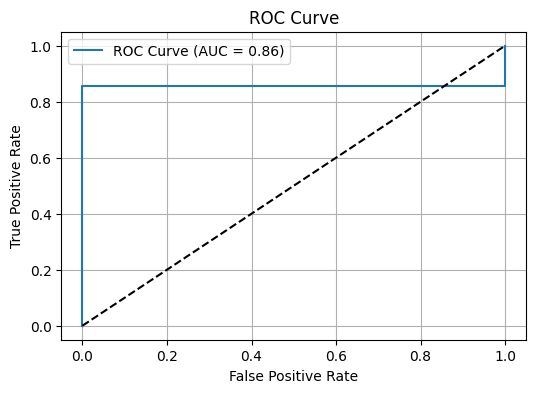

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

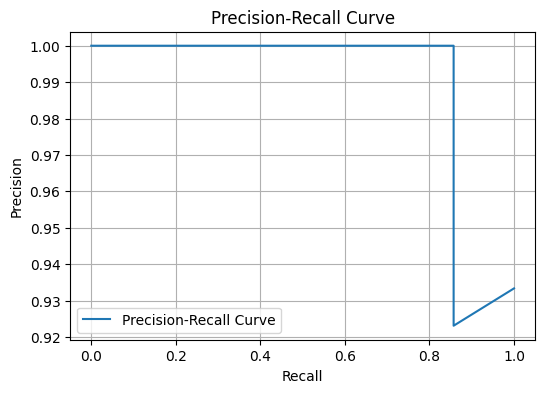

In [ ]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

<Figure size 800x600 with 0 Axes>

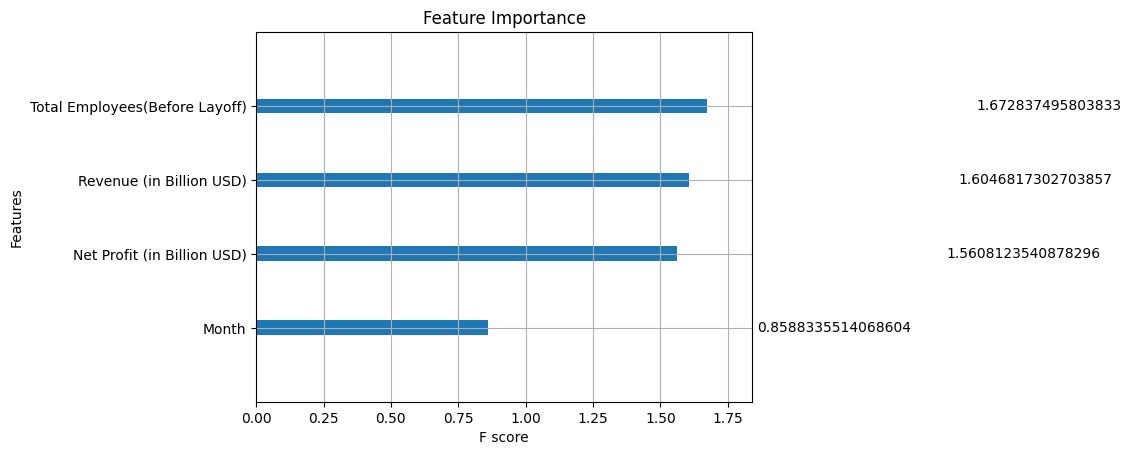

In [ ]:
# Feature Importance
plt.figure(figsize=(8,6))
plot_importance(model, importance_type='gain', title='Feature Importance', max_num_features=10)
plt.show()